# Loan and housing data —PCA and clustering

---
por [<span style="font-family:monospace;">Andres Ethorimn</span>](https://www.linkedin.com/in/ethlob/) 👨🏾‍💻

<span style="color:green; font-weight:bold;">Clustering:</span> en este notebook vamos a aplicar técnicas de reducción de dimensionalidad y clustering no supervisado sobre los datos preprocesados. Utilizaremos PCA para reducir la complejidad dimensional y posteriormente implementaremos algoritmos de clustering como K-means y clustering espectral para identificar patrones y segmentos naturales en los datos, evaluando la calidad de los clusters mediante métricas como el coeficiente de silueta y visualizaciones.

<span style="font-size:small; color:gray;">*Los notebooks en esta sección son prototipos. Su uso es exclusivo para exploración y aprendizaje, y no están pensado para usarse en producción. Tenga presente que los comentarios de aquí en adelante estarán en inglés por ser el idioma estándar de la industria.*</span>

In [22]:
# Import neccessary libraries
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from collections import Counter
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from imblearn.under_sampling import (
    TomekLinks, 
    RandomUnderSampler,
)

from pycaret.clustering import ClusteringExperiment

In [23]:
# Define data directory
parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, 'data')

In [24]:
# Set random state for further implementations
random_state = 11

In [25]:
# Load the data from the Excel file in staging directory
data_feature = pd.read_excel(os.path.join(data_dir, 'staging', '02_data_prueba_ds_loan_housing_eda_imputation_prune.xlsx'), engine='openpyxl', index_col=0)
data_target = pd.read_excel(os.path.join(data_dir, 'staging', '02_data_prueba_ds_loan_housing_target.xlsx'), engine='openpyxl', index_col=0)
data_contact = pd.read_excel(os.path.join(data_dir, 'staging', '02_data_prueba_ds_loan_housing_contacted.xlsx'), engine='openpyxl', index_col=0)

In [26]:
features_index = data_feature.index

data_target = data_target.loc[features_index, :]
data_contact = data_contact.loc[features_index, :]

In [27]:
tomek_undersampler = TomekLinks(sampling_strategy = 'not minority', n_jobs = -1)
random_undersampler = RandomUnderSampler(sampling_strategy = 'not minority', random_state = random_state, replacement = False)

data_feature_under, data_target_under = tomek_undersampler.fit_resample(data_feature, data_target.target)
data_feature_under, data_target_under = random_undersampler.fit_resample(data_feature_under, data_target_under)

In [28]:
print('<---- Basic data description ---->')
print('Number of features for each class before undersampling:')
display(Counter(data_target.target))

print('<---- Basic data description ---->')
print('Number of features for each class after undersampling:')
display(Counter(data_target_under))

<---- Basic data description ---->
Number of features for each class before undersampling:


Counter({0: 3831, 2: 3278, 3: 609, 1: 465})

<---- Basic data description ---->
Number of features for each class after undersampling:


Counter({0: 438, 1: 438, 2: 438, 3: 438})

In [29]:
# PCA no supervisado
pca = PCA(n_components = 10, random_state = random_state)
pca.fit(data_feature_under)

data_pca = pca.transform(data_feature_under)

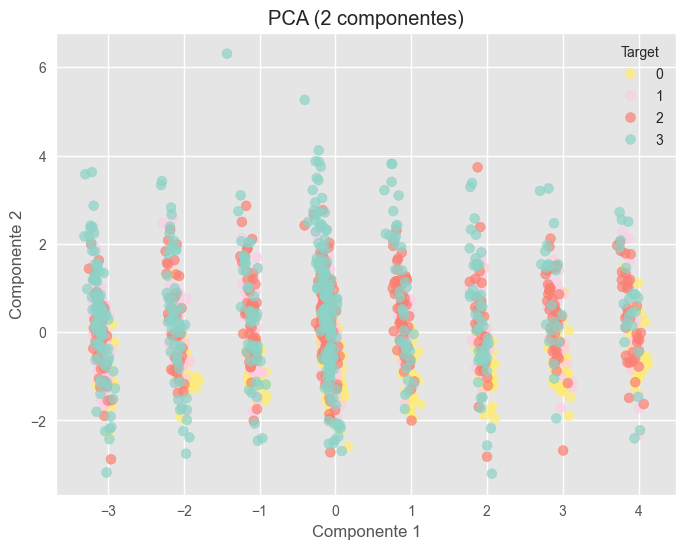

In [43]:
# 2D visualization of the first two principal components
plt.figure(figsize=(8, 6))
scatter_2d = plt.scatter(
    data_pca[:, 0], data_pca[:, 1],
    c=data_target_under, cmap='Set3_r', alpha=0.7
)
plt.title('PCA (2 componentes)')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(*scatter_2d.legend_elements(), title="Target")
plt.show()


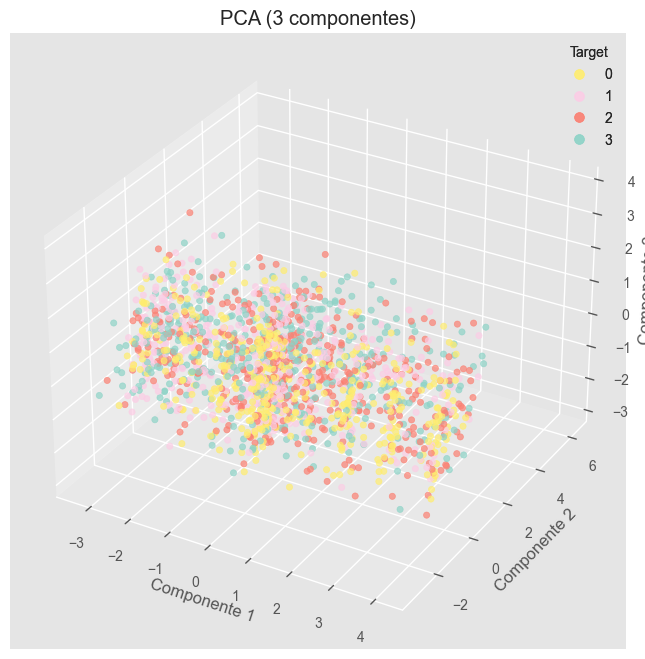

In [31]:
# Visualización
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    data_pca[:, 0], data_pca[:, 1], data_pca[:, 2],
    c=data_target_under, cmap='Set3_r', alpha=0.7
)
ax.set_title('PCA (3 componentes)')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
legend1 = ax.legend(*scatter.legend_elements(), title="Target")
ax.add_artist(legend1)
plt.show()

In [ ]:
# Print the variance explained by each component
print(f'Varianza explicada por cada componente: {pca.explained_variance_ratio_}')

Varianza explicada por cada componente: [0.26457617 0.08138902 0.07328349 0.06658118 0.0554619  0.05500777
 0.05348471 0.05069194 0.04997804 0.04799903]


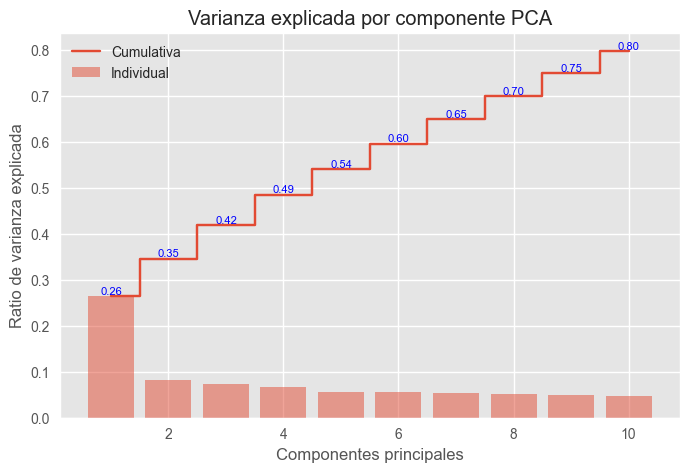

In [33]:
var_ratio = pca.explained_variance_ratio_

cum_var = np.cumsum(var_ratio)

plt.figure(figsize=(8,5))
plt.bar(range(1, len(var_ratio)+1), var_ratio, alpha=0.5, label='Individual')
plt.step(range(1, len(cum_var)+1), cum_var, where='mid', label='Cumulativa')

for i, cv in enumerate(np.cumsum(var_ratio)):
    plt.text(i + 1, cv, f'{cv:.2f}', ha='center', va='bottom', fontsize=8, color='blue')

plt.xlabel('Componentes principales')
plt.ylabel('Ratio de varianza explicada')
plt.title('Varianza explicada por componente PCA')
plt.legend()
plt.show()

In [34]:
# Create a DataFrame from data_pca with appropriate index and column names
pca_columns = [f'comp_{i+1}' for i in range(data_pca.shape[1])]
data_pca_frame = pd.DataFrame(data_pca, index = data_feature_under.index, columns = pca_columns)

In [35]:
experiment = ClusteringExperiment()

experiment.setup(
    data_pca_frame,
    preprocess = True,
    imputation_type = None,
    session_id = random_state,
    n_jobs = -1,
    use_gpu = True,
)

In [36]:
kmeans, afinity_prop, spectral_clustering = (
    experiment.create_model('kmeans', num_clusters = 10, random_state = random_state),
    experiment.create_model('ap', random_state = random_state),
    experiment.create_model('sc', n_clusters=10, random_state = random_state)
)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0793,148.1028,2.4802,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0697,32.1457,1.8405,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1140,241.6431,1.8255,0,0,0


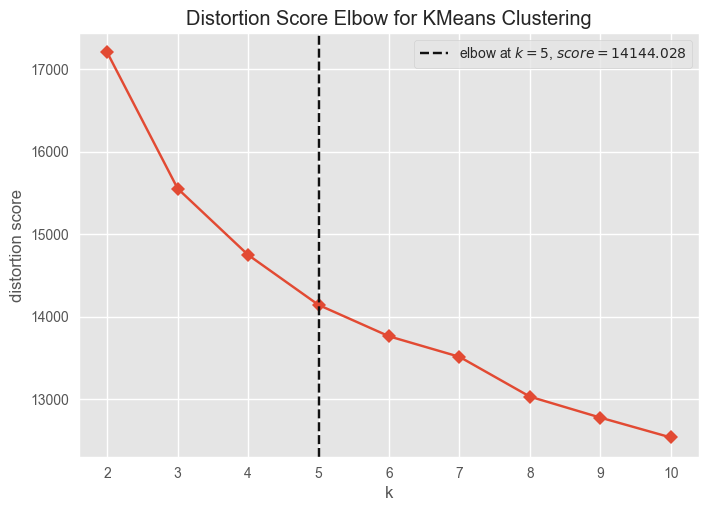

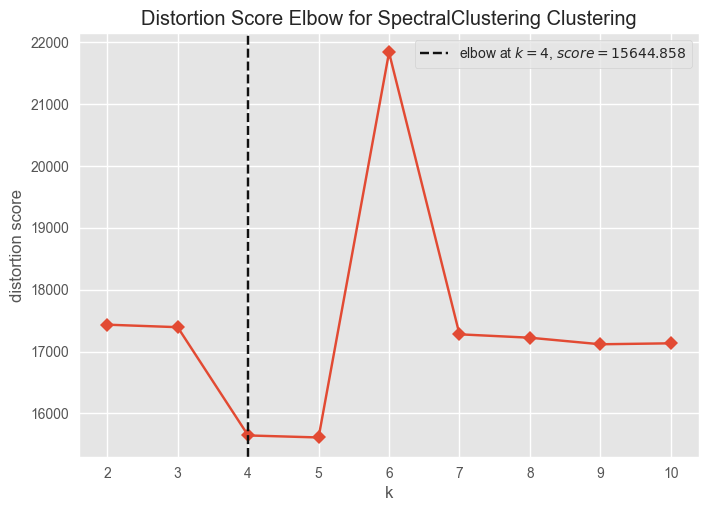

In [37]:
%matplotlib inline
experiment.plot_model(kmeans, plot = 'elbow')
experiment.plot_model(spectral_clustering, plot = 'elbow')

In [38]:
best_kmeans, best_spectral_clustering = (
    experiment.create_model('kmeans', num_clusters = 4, random_state = random_state),
    experiment.create_model('sc', n_clusters = 4, random_state = random_state)
)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1227,291.6437,2.3582,0,0,0


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.1140,241.6431,1.8255,0,0,0


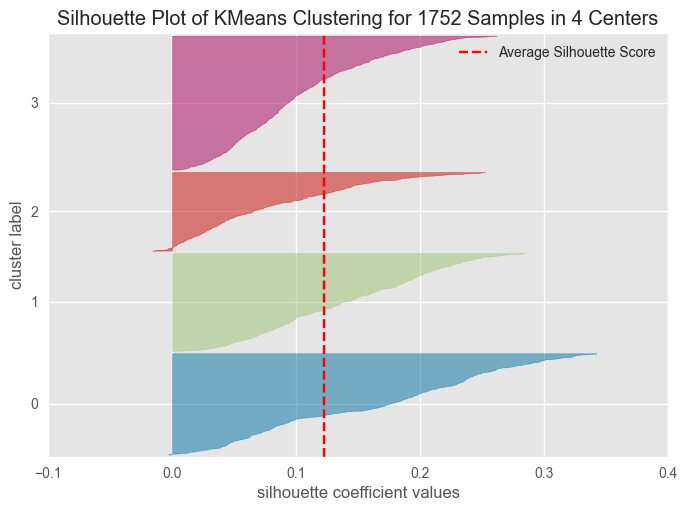

In [39]:
%matplotlib inline
experiment.plot_model(best_kmeans, plot = 'silhouette')
experiment.plot_model(best_kmeans, plot = 'cluster')
experiment.plot_model(best_kmeans, plot = 'distribution')

In [40]:
best_kmeans_df = experiment.assign_model(best_kmeans)
best_kmeans_df = best_kmeans_df.loc[:, ['Cluster']].rename(columns = {'Cluster': 'cluster'})

In [41]:
best_kmeans_df.to_excel(os.path.join(data_dir, 'staging', '03_data_prueba_ds_loan_housing_clusters.xlsx'), index=True, engine='openpyxl')

In [42]:
experiment.save_model(best_kmeans, model_name = os.path.join(parent_dir, 'models', '03_best_kmeans_pca'), model_only = True, verbose = True)

Model Successfully Saved


(KMeans(n_clusters=4, random_state=11),
 'c:\\Users\\USUARIO\\OneDrive\\Documents\\Compilaciones\\adl-ds-semisenior\\models\\03_best_kmeans_pca.pkl')